In [1]:
import sys
import os
import random
import pickle
import numpy as np
from preprocessing import make_delayed
from preprocessing import downsample_word_vectors
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# Add the root project folder to sys.path (so ridge_utils becomes importable)
project_root = os.path.abspath('..')  # moves up from 'code/'
sys.path.append(project_root)

In [2]:
# Load the raw_text.pkl file
path_to_data = '/ocean/projects/mth240012p/shared/data'
with open(f'{path_to_data}/raw_text.pkl', 'rb') as f:
    raw_text = pickle.load(f)

print(type(raw_text))
print(len(raw_text)) # total 109 stories


<class 'dict'>
109


Before splitting the stories into train and test, since there are 8 more stories in the raw_text file than in the stories in subject 2 and 3, we exclude these stories since they cannot be used for both test or train. 

In [3]:
all_stories = set(raw_text.keys())
subj2_stories = set(os.path.splitext(f)[0] for f in os.listdir(f'{path_to_data}/subject2') if f.endswith('.npy'))
subj3_stories = set(os.path.splitext(f)[0] for f in os.listdir(f'{path_to_data}/subject3') if f.endswith('.npy'))
print(subj2_stories == subj3_stories) #fortunately, subject 2 and 3 has same stories
valid_stories = sorted(list(all_stories & subj2_stories & subj3_stories))
print(len(valid_stories)) 


True
101


Now we split test stories, train stories (3:7)

In [4]:
#we will just rename valid_stories as all_stories for the sake of simplicity.
all_stories = valid_stories
random.seed(42)
random.shuffle(all_stories)
split_idx = int(0.7 * len(all_stories))  # 70% for training

train_stories = all_stories[:split_idx]
test_stories = all_stories[split_idx:]

print(f"Train stories: {len(train_stories)}")
print(f"Test stories: {len(test_stories)}")
train_stories.sort()
test_stories.sort()

Train stories: 70
Test stories: 31


In [5]:
#compute and append all words in train_stories
allwords = []
for story in train_stories:
    temp_text = raw_text[story].data
    allwords += temp_text

print(len(allwords))

#compute unique words in train_stories
unique_words = list(set(allwords))
len(unique_words)

137105


10360

**Bert method**
Now we do the same process for Bert method.

1. Make vectors for each word in train_stories
Create matrices for each stories. 

We use the pretrained model that we got from part 1 that gives a vector of length 128 for each word in train stories. 

In [6]:
# the best bin file with best hyperparameters is saved in embeddings folder
# named as bert_embeddings_hs128_nl4_do1_lr5e-04.bin
model_path = '../embeddings/bert_embeddings_hs128_nl4_do1_lr5e-04.bin'
bert_kv = KeyedVectors.load_word2vec_format(model_path, binary=True)


Now, we explore the bert model that we trained a bit. 
We can see that each word has vector of length 128. 

In addiiton, we can see that the bert model fails to capture semantic similarity between two obviously related words. 

BERT is more advanced because it produces contextual, sentence-aware embeddings using deep Transformer networks. Unlike Word2Vec and GloVe, it can generate different vectors for the same word depending on context.
However, our model was trained on a very small corpus (~70 stories), which is far too limited to capture broad semantic relationships between words. As a result, words like "king" and "queen" show near-zero similarity, despite BERT's more sophisticated structure.

In [7]:
#explore Bert model
print("Total number of words in bert model:", len(bert_kv))

# See that the tokens include words
print(bert_kv.index_to_key[2000:2020])

# Get the embedding vector for a word
print("bert vector for the word computer: ")
print(bert_kv['computer'][:20])  
print("length of one vector per word: ")
print(len(bert_kv['computer']))

# Exploring similarities between related words
print(bert_kv.similarity('man', 'woman'))  
print(bert_kv.similarity('king', 'queen'))
print(bert_kv.similarity('dog', 'cat'))
print(bert_kv.similarity('university', 'school'))

Total number of words in bert model: 30522
['to', 'was', 'he', 'is', 'as', 'for', 'on', 'with', 'that', 'it', 'his', 'by', 'at', 'from', 'her', '##s', 'she', 'you', 'had', 'an']
bert vector for the word computer: 
[ 0.9458338   0.15190326  1.8394665  -0.23154294 -0.29065335 -0.32959467
 -0.08935024  1.8204935  -0.53045    -0.10182022  0.4668317   0.2767857
  0.99448705  1.1338542  -0.54352254 -1.2883255  -0.5961788   0.3923459
 -0.0426691   1.4427829 ]
length of one vector per word: 
128
-0.18327945
-0.09025575
-0.05577983
-0.02571407


First, we check if the Bert model includes all the unique words for all the words in train_stories.
We use unique_words that we defined earlier. 
We see below that about 25% of the words are not defined in w2v. 
This is significantly higher than the w2v and glove model. This seems obvious since as we mentioned before, our training data was too small. 

In [8]:
in_model = [word for word in unique_words if word in bert_kv]
not_in_model = [word for word in unique_words if word not in bert_kv]
print(f"Percentage of words Not in bert model: {len(not_in_model)/len(unique_words):.4f}")

Percentage of words Not in bert model: 0.2497


In [9]:
#vector_size = 128 which is from the pretrained model

def embed_story_words(word_list, model, vector_size):
    embedded = []
    for word in word_list:
        if word in model:
            embedded.append(model[word])
        else:
            embedded.append(np.zeros(vector_size))  # unknown word
    return np.vstack(embedded)

In [10]:
vector_size = 128 #of pretrained model 
story_vectors_bert = {} 
#Dictionary where key is story name and value is matrix, whose vectors correspond to each word in story

for story in train_stories:
    words = raw_text[story].data
    story_vectors_bert[story] = embed_story_words(words, bert_kv, vector_size)

2. Downsample and Trim for matrices made by bert model

In [11]:
#made dictionary whose keys are name of train story and values are raw_text[story]
wordseqs = {story: raw_text[story] for story in train_stories}
downsampled_vectors_bert = downsample_word_vectors(
    stories=train_stories,
    word_vectors=story_vectors_bert,
    wordseqs=wordseqs
)

In [12]:
trimmed_vectors_bert = {} #trimmed matrices for each train story 

for story, matrix in downsampled_vectors_bert.items():
    trimmed_matrix = matrix[5:-10]
    trimmed_vectors_bert[story] = trimmed_matrix


3. Creating lagged versions

Since the current number of columns for each matrix ix 128, 
the new matrices will have 128*4=512 columns.

In [13]:
delayed_vectors_bert = {}

for story, trimmed_matrix in trimmed_vectors_bert.items():
    X_lagged = make_delayed(trimmed_matrix, delays=[1, 2, 3, 4])
    delayed_vectors_bert[story] = X_lagged

# check for first trimmed,delayed matrix, which corresponds to first story
for key, value in delayed_vectors_bert.items():
    print("First key:", key)
    print("delayed matrix for first story is", value.shape)
    break

First key: adventuresinsayingyes
delayed matrix for first story is (391, 512)


Now we make embeddings for test stories.

In [14]:
story_vectors_bert_test = {}
for story in test_stories:
    words = raw_text[story].data
    story_vectors_bert_test[story] = embed_story_words(words, bert_kv, vector_size)

wordseqs2 = {story: raw_text[story] for story in test_stories}
downsampled_vectors_bert_test = downsample_word_vectors(
    stories=test_stories,
    word_vectors=story_vectors_bert_test,
    wordseqs=wordseqs2
)

trimmed_vectors_bert_test = {} #trimmed matrices for each test story 
for story, matrix in downsampled_vectors_bert_test.items():
    trimmed_matrix = matrix[5:-10]
    trimmed_vectors_bert_test[story] = trimmed_matrix

delayed_vectors_bert_test = {}
for story, trimmed_matrix in trimmed_vectors_bert_test.items():
    X_lagged = make_delayed(trimmed_matrix, delays=[1, 2, 3, 4])
    delayed_vectors_bert_test[story] = X_lagged

print(len(delayed_vectors_bert_test))

31


In [15]:
import gc
del bert_kv
del raw_text
gc.collect()


0

PART 2

**Subject2**

In [16]:
from ridge_utils.ridge import ridge_corr, ridge_corr_pred
import numpy as np
import logging
from ridge_utils.ridge import ridge_corr
from ridge_utils.utils import mult_diag
import random
from sklearn.model_selection import KFold

Now that we have made all the three train and test dictionaries, we will Y_test and Y_train for subject 2.

In [17]:
path_s2 = '/ocean/projects/mth240012p/shared/data/subject2/'
Y_s2_train_dict = {}
for story in train_stories:
    Y_s2_train_dict[story] = np.load(path_s2 + f"{story}.npy")
Y_s2_test_dict = {}
for story in test_stories:
    Y_s2_test_dict[story] = np.load(path_s2 + f"{story}.npy")

In [18]:
#Test for bert, subject 2
# Stack X to make matrix
X_train_full = np.vstack([delayed_vectors_bert[s] for s in train_stories]) 
X_test_full = np.vstack([delayed_vectors_bert_test[s] for s in test_stories])    

# Stack Y2 to make one matrix
Y_train_s2 = np.vstack([Y_s2_train_dict[s] for s in train_stories])
Y_test_s2 = np.vstack([Y_s2_test_dict[s] for s in test_stories])

2(1). First we fit ridge regression. 

Since we don't know the alphas(hyperparameters) yet, we try with alpha = 1 for all voxels. 

In [19]:
logging.basicConfig(level=logging.INFO)
ridge_logger = logging.getLogger("ridge_corr")
zs = lambda v: (v - v.mean(0)) / v.std(0)

X_train_full = zs(X_train_full)
X_test_full = zs(X_test_full)
Y_train_s2 = zs(Y_train_s2)
Y_test_s2 = zs(Y_test_s2)

In [20]:
#subject 2
num_vox_s2 = 94251
corr_s2 = ridge_corr_pred(X_train_full, X_test_full, Y_train_s2, Y_test_s2, valphas= np.ones(num_vox_s2))
mean_cc_2 = np.mean(corr_s2[np.isfinite(corr_s2)]) #exclude
print("Mean CC for sub2:", mean_cc_2)
#We can see that when alphas are poorly set, the mean CC across voxels are very low. 

INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (24955, 512))
INFO:ridge_corr:Training stimulus has LSV norm: 553.265
INFO:ridge_corr:Average difference between actual & assumed Prespvar: nan


Mean CC for sub2: 0.003193921716304345


2(1). CV 

We use 5-fold CV to get best alphas for each voxel. 

We first splitted 70 training stories into 5 fold CV (8:2 for train and valid), run ridge_corr for all folds yielding five alpha*CCs matrices, Compute the mean across the matrices, and then select the alpha with the highest mean CC for each voxel. 

**subject 2**

In [21]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# 5-fold cross-validation on training stories
kf = KFold(n_splits=5, shuffle=True, random_state=42)
alphas = np.logspace(1, 4, 10)  # 10 values from 10 to 10000
Rcorrs_folds = []  # Store Rcorrs for each fold

for fold, (train_idx, val_idx) in enumerate(kf.split(train_stories)):
    print(f"Processing fold {fold + 1}/5 for bert")

    # Get the story names for this fold
    train = [train_stories[i] for i in train_idx]  # 56 stories
    val = [train_stories[i] for i in val_idx]      # 14 stories

    # Stack X and Y for this fold
    X_train = np.vstack([delayed_vectors_bert[s] for s in train]) 
    X_val = np.vstack([delayed_vectors_bert[s] for s in val])      
    Y_train = np.vstack([Y_s2_train_dict[s] for s in train])    
    Y_val = np.vstack([Y_s2_train_dict[s] for s in val])       

    # Z-score 
    X_train = zs(X_train)
    X_val = zs(X_val)
    Y_train = zs(Y_train)
    Y_val = zs(Y_val)

    # Run ridge_corr on this fold
    Rcorrs = ridge_corr(X_train, X_val, Y_train, Y_val, alphas, use_corr=True)
    Rcorrs = np.array(Rcorrs)  # (10, 94251)
    Rcorrs_folds.append(Rcorrs)

# Average Rcorrs across folds
Rcorrs_folds = np.array(Rcorrs_folds)  # (5, 10, 94251)
Rcorrs_5foldmean = Rcorrs_folds.mean(axis=0)  # (10, 94251)
# Select best alpha for each voxel
best_alpha_idx_s2 = np.argmax(Rcorrs_5foldmean, axis=0)  # (94251,)
valphas_s2 = alphas[best_alpha_idx_s2]  # (94251,)


Processing fold 1/5 for bert


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19805, 512))
INFO:ridge_corr:Training stimulus has LSV norm: 483.240
INFO:ridge_corr:Average difference between actual & assumed Prespvar: nan
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00106, max corr=0.06930, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00111, max corr=0.06926, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00131, max corr=0.07089, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00196, max corr=0.07682, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.00296, max corr=0.07917, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.00359, max corr=0.07182, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.00380, max corr=0.07055, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.00385, max corr=0.07110, over-under(0

Processing fold 2/5 for bert


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (20078, 512))
INFO:ridge_corr:Training stimulus has LSV norm: 502.014
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00226, max corr=0.06980, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00230, max corr=0.06945, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00244, max corr=0.06783, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00281, max corr=0.07007, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.00338, max corr=0.07150, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.00384, max corr=0.08165, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.00403, max corr=0.08927, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.00407, max corr=0.09144, over-under

Processing fold 3/5 for bert


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19633, 512))
INFO:ridge_corr:Training stimulus has LSV norm: 496.160
INFO:ridge_corr:Average difference between actual & assumed Prespvar: -0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00186, max corr=0.07825, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00187, max corr=0.07842, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00194, max corr=0.07869, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00218, max corr=0.07993, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.00263, max corr=0.09292, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.00293, max corr=0.09670, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.00300, max corr=0.09572, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.00300, max corr=0.09523, over-unde

Processing fold 4/5 for bert


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (20077, 512))
INFO:ridge_corr:Training stimulus has LSV norm: 502.754
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00179, max corr=0.08039, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00183, max corr=0.08079, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00200, max corr=0.08206, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00255, max corr=0.08292, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.00350, max corr=0.08150, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.00415, max corr=0.08009, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.00436, max corr=0.08084, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.00440, max corr=0.08150, over-under

Processing fold 5/5 for bert


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (20227, 512))
INFO:ridge_corr:Training stimulus has LSV norm: 490.267
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00354, max corr=0.09519, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00358, max corr=0.09558, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00374, max corr=0.09692, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00412, max corr=0.09946, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.00474, max corr=0.10919, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.00536, max corr=0.11219, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.00563, max corr=0.10873, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.00570, max corr=0.10680, over-under

In [22]:
#given valphas, we calculate test CCs on test stories. 
final_ccs_s2 = ridge_corr_pred(X_train_full, X_test_full, Y_train_s2, Y_test_s2, valphas_s2)

valid_ccs_s2 = final_ccs_s2[np.isfinite(final_ccs_s2)]  # Exclude NaNs/infs
mean_cc_s2 = np.mean(valid_ccs_s2)
median_cc_s2 = np.median(valid_ccs_s2)
top_1_percentile_cc_s2 = np.percentile(valid_ccs_s2, 99)  # Top 1 percentile
top_5_percentile_cc_s2 = np.percentile(valid_ccs_s2, 95)  # Top 5 percentile

# Print statistics
print(f"Mean test CC for subject 2 (bert): {mean_cc_s2}")
print(f"Median test CC for subject 2 (bert): {median_cc_s2}")
print(f"Top 1 percentile test CC for subject 2 (bert): {top_1_percentile_cc_s2}")
print(f"Top 5 percentile test CC for subject 2 (bert): {top_5_percentile_cc_s2}")


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (24955, 512))
INFO:ridge_corr:Training stimulus has LSV norm: 553.265
INFO:ridge_corr:Average difference between actual & assumed Prespvar: nan


Mean test CC for subject 2 (bert): 0.004973636650563277
Median test CC for subject 2 (bert): 0.004546204567400616
Top 1 percentile test CC for subject 2 (bert): 0.03551929516552277
Top 5 percentile test CC for subject 2 (bert): 0.025174768039896538


In [23]:
del Y_s2_train_dict
del Y_s2_test_dict
del Y_test_s2
del Y_train_s2
del Rcorrs_folds, Rcorrs_5foldmean

gc.collect()

11

Subject 3

In [24]:
path_s3 = '/ocean/projects/mth240012p/shared/data/subject3/'
Y_s3_train_dict = {}
for story in train_stories:
    Y_s3_train_dict[story] = np.load(path_s3 + f"{story}.npy")
Y_s3_test_dict = {}
for story in test_stories:
    Y_s3_test_dict[story] = np.load(path_s3 + f"{story}.npy")

In [25]:
#Stack Y3 to make one matrix
Y_train_s3 = np.vstack([Y_s3_train_dict[s] for s in train_stories])
Y_test_s3 = np.vstack([Y_s3_test_dict[s] for s in test_stories])
Y_train_s3 = zs(Y_train_s3)
Y_test_s3 = zs(Y_test_s3)

2(1). Fitting Regression on alphas=1 for subject 3

In [26]:
#subject3
num_vox_s3 = 95556
corr_s3 = ridge_corr_pred(X_train_full, X_test_full, Y_train_s3, Y_test_s3, valphas= np.ones(num_vox_s3))
mean_cc_3 = np.mean(corr_s3[np.isfinite(corr_s3)]) #exclude
print("Mean CC for sub3:", mean_cc_3)

INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (24955, 512))
INFO:ridge_corr:Training stimulus has LSV norm: 553.265
INFO:ridge_corr:Average difference between actual & assumed Prespvar: -0.000


Mean CC for sub3: 0.005163527952520837


2(2). CV

In [27]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# 5-fold cross-validation on training stories
kf = KFold(n_splits=5, shuffle=True, random_state=42)
alphas = np.logspace(1, 4, 10)  #increase alpha range
Rcorrs_folds = []  # Reset for subject 3

for fold, (train_idx, val_idx) in enumerate(kf.split(train_stories)):
    print(f"Processing fold {fold + 1}/5 for w2v (subject 3)")

    train = [train_stories[i] for i in train_idx]  # 56 stories
    val = [train_stories[i] for i in val_idx]      # 14 stories

    # Stack X and Y for this fold
    X_train = np.vstack([delayed_vectors_bert[s] for s in train]) 
    X_val = np.vstack([delayed_vectors_bert[s] for s in val])      
    Y_train = np.vstack([Y_s3_train_dict[s] for s in train])    
    Y_val = np.vstack([Y_s3_train_dict[s] for s in val])       

    # Z-score 
    X_train = zs(X_train)
    X_val = zs(X_val)
    Y_train = zs(Y_train)
    Y_val = zs(Y_val)

    # Run ridge_corr on this fold
    Rcorrs = ridge_corr(X_train, X_val, Y_train, Y_val, alphas, use_corr=True)
    Rcorrs = np.array(Rcorrs)  # (10, 94251)
    Rcorrs_folds.append(Rcorrs)

# Average Rcorrs across folds
Rcorrs_folds = np.array(Rcorrs_folds)  # (5, 10, 95556)
Rcorrs_5foldmean = Rcorrs_folds.mean(axis=0)  # (10, 95556)

# Select best alpha for each voxel
best_alpha_idx_s3 = np.argmax(Rcorrs_5foldmean, axis=0)  # (95556,)
valphas_s3 = alphas[best_alpha_idx_s3]  # (95556,)


Processing fold 1/5 for w2v (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19805, 512))
INFO:ridge_corr:Training stimulus has LSV norm: 483.240
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00456, max corr=0.07628, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00463, max corr=0.07644, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00489, max corr=0.07773, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00556, max corr=0.07929, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.00650, max corr=0.08392, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.00705, max corr=0.08522, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.00713, max corr=0.08559, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.00711, max corr=0.08567, over-under

Processing fold 2/5 for w2v (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (20078, 512))
INFO:ridge_corr:Training stimulus has LSV norm: 502.014
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00585, max corr=0.10731, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00592, max corr=0.10767, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00624, max corr=0.10888, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00718, max corr=0.11024, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.00876, max corr=0.11907, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.00992, max corr=0.11821, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.01031, max corr=0.11641, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01039, max corr=0.11587, over-under

Processing fold 3/5 for w2v (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19633, 512))
INFO:ridge_corr:Training stimulus has LSV norm: 496.160
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00776, max corr=0.14218, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00786, max corr=0.14340, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00825, max corr=0.14787, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00919, max corr=0.15737, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01010, max corr=0.16279, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.01018, max corr=0.15434, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.00994, max corr=0.14289, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.00983, max corr=0.13803, over-under

Processing fold 4/5 for w2v (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (20077, 512))
INFO:ridge_corr:Training stimulus has LSV norm: 502.754
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00499, max corr=0.09664, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00506, max corr=0.09703, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00536, max corr=0.09904, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00623, max corr=0.10544, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.00756, max corr=0.10785, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.00850, max corr=0.10359, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.00878, max corr=0.10566, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.00882, max corr=0.10565, over-under

Processing fold 5/5 for w2v (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (20227, 512))
INFO:ridge_corr:Training stimulus has LSV norm: 490.267
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00568, max corr=0.11521, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00578, max corr=0.11522, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00614, max corr=0.11503, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00713, max corr=0.11569, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.00839, max corr=0.11500, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.00881, max corr=0.12224, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.00869, max corr=0.12273, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.00861, max corr=0.12261, over-under

In [28]:
# Given valphas, calculate test CCs on test stories
final_ccs_s3 = ridge_corr_pred(X_train_full, X_test_full, Y_train_s3, Y_test_s3, valphas_s3, use_corr=True)

# Compute statistics for subject 3
valid_ccs_s3 = final_ccs_s3[np.isfinite(final_ccs_s3)]  # Exclude NaNs/infs
mean_cc_s3 = np.mean(valid_ccs_s3)
median_cc_s3 = np.median(valid_ccs_s3)
top_1_percentile_cc_s3 = np.percentile(valid_ccs_s3, 99)  # Top 1 percentile
top_5_percentile_cc_s3 = np.percentile(valid_ccs_s3, 95)  # Top 5 percentile

# Print statistics
print(f"Mean test CC for subject 3 (bert): {mean_cc_s3}")
print(f"Median test CC for subject 3 (bert): {median_cc_s3}")
print(f"Top 1 percentile test CC for subject 3 (bert): {top_1_percentile_cc_s3}")
print(f"Top 5 percentile test CC for subject 3 (bert): {top_5_percentile_cc_s3}")

INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (24955, 512))
INFO:ridge_corr:Training stimulus has LSV norm: 553.265
INFO:ridge_corr:Average difference between actual & assumed Prespvar: -0.000


Mean test CC for subject 3 (bert): 0.007682888157187455
Median test CC for subject 3 (bert): 0.006588791499071744
Top 1 percentile test CC for subject 3 (bert): 0.047333469911959615
Top 5 percentile test CC for subject 3 (bert): 0.032459205603617404


Drawing the CC distribution for Bert

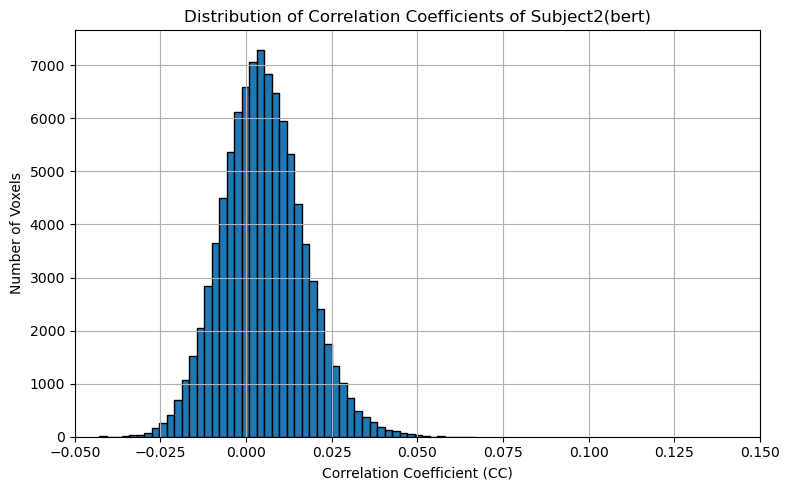

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.hist(valid_ccs_s2, bins=50, edgecolor='black')
plt.title('Distribution of Correlation Coefficients of Subject2(bert)')
plt.xlabel('Correlation Coefficient (CC)')
plt.ylabel('Number of Voxels')
plt.grid(True)
plt.xlim(-0.05, 0.15)
plt.savefig("../figs/distribution_bert_2.png", dpi=300)
plt.tight_layout()
plt.show()

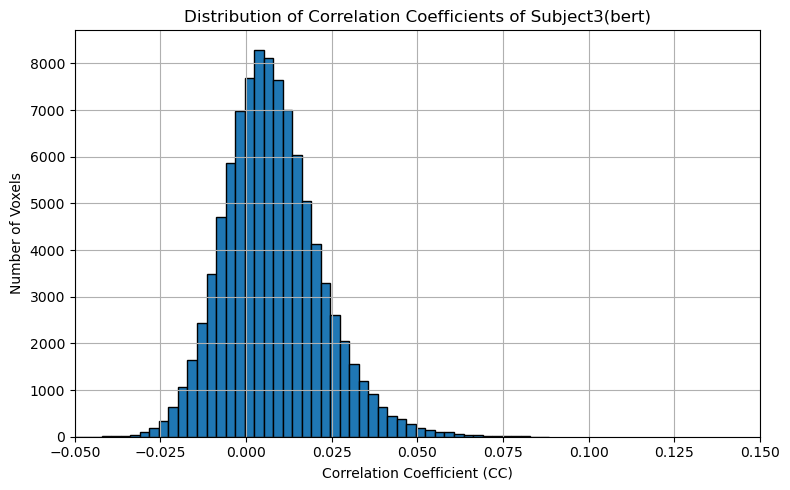

In [30]:
plt.figure(figsize=(8, 5))
plt.hist(valid_ccs_s3, bins=50, edgecolor='black')
plt.title('Distribution of Correlation Coefficients of Subject3(bert)')
plt.xlabel('Correlation Coefficient (CC)')
plt.ylabel('Number of Voxels')
plt.grid(True)
plt.xlim(-0.05, 0.15)
plt.savefig("../figs/distribution_bert_3.png", dpi=300)
plt.tight_layout()
plt.show()

Now we perform stability check, as we did before and re-split train and test stories. 

In [31]:
path_to_data = '/ocean/projects/mth240012p/shared/data'
with open(f'{path_to_data}/raw_text.pkl', 'rb') as f:
    raw_text = pickle.load(f)

all_stories = set(raw_text.keys())
subj2_stories = set(os.path.splitext(f)[0] for f in os.listdir(f'{path_to_data}/subject2') if f.endswith('.npy'))
subj3_stories = set(os.path.splitext(f)[0] for f in os.listdir(f'{path_to_data}/subject3') if f.endswith('.npy'))
print(subj2_stories == subj3_stories) #fortunately, subject 2 and 3 has same stories
valid_stories = sorted(list(all_stories & subj2_stories & subj3_stories))
all_stories = valid_stories

random.seed(214)
random.shuffle(all_stories)
split_idx = int(0.7 * len(all_stories))  # 70% for training

train_stories = all_stories[:split_idx]
test_stories = all_stories[split_idx:]

train_stories.sort()
test_stories.sort()

allwords = []
for story in train_stories:
    temp_text = raw_text[story].data
    allwords += temp_text

print(len(allwords))

#compute unique words in train_stories
unique_words = list(set(allwords))


def embed_story_words(word_list, model, vector_size):
    embedded = []
    for word in word_list:
        if word in model:
            embedded.append(model[word])
        else:
            embedded.append(np.zeros(vector_size))  # unknown word
    return np.vstack(embedded)

True
133972


In [32]:
model_path = '../embeddings/bert_embeddings_hs128_nl4_do1_lr5e-04.bin'
bert_kv = KeyedVectors.load_word2vec_format(model_path, binary=True)

vector_size = 128 #of pretrained model 
story_vectors_bert = {} 
#Dictionary where key is story name and value is matrix, whose vectors correspond to each word in story

for story in train_stories:
    words = raw_text[story].data
    story_vectors_bert[story] = embed_story_words(words, bert_kv, vector_size)

#made dictionary whose keys are name of train story and values are raw_text[story]
wordseqs = {story: raw_text[story] for story in train_stories}
downsampled_vectors_bert = downsample_word_vectors(
    stories=train_stories,
    word_vectors=story_vectors_bert,
    wordseqs=wordseqs
)
trimmed_vectors_bert = {} #trimmed matrices for each train story 

for story, matrix in downsampled_vectors_bert.items():
    trimmed_matrix = matrix[5:-10]
    trimmed_vectors_bert[story] = trimmed_matrix
delayed_vectors_bert = {}

for story, trimmed_matrix in trimmed_vectors_bert.items():
    X_lagged = make_delayed(trimmed_matrix, delays=[1, 2, 3, 4])
    delayed_vectors_bert[story] = X_lagged

story_vectors_bert_test = {}
for story in test_stories:
    words = raw_text[story].data
    story_vectors_bert_test[story] = embed_story_words(words, bert_kv, vector_size)

wordseqs2 = {story: raw_text[story] for story in test_stories}
downsampled_vectors_bert_test = downsample_word_vectors(
    stories=test_stories,
    word_vectors=story_vectors_bert_test,
    wordseqs=wordseqs2
)

trimmed_vectors_bert_test = {} #trimmed matrices for each test story 
for story, matrix in downsampled_vectors_bert_test.items():
    trimmed_matrix = matrix[5:-10]
    trimmed_vectors_bert_test[story] = trimmed_matrix

delayed_vectors_bert_test = {}
for story, trimmed_matrix in trimmed_vectors_bert_test.items():
    X_lagged = make_delayed(trimmed_matrix, delays=[1, 2, 3, 4])
    delayed_vectors_bert_test[story] = X_lagged

print(len(delayed_vectors_bert_test))

INFO:gensim.models.keyedvectors:loading projection weights from ../embeddings/bert_embeddings_hs128_nl4_do1_lr5e-04.bin
INFO:gensim.utils:KeyedVectors lifecycle event {'msg': 'loaded (30522, 128) matrix of type float32 from ../embeddings/bert_embeddings_hs128_nl4_do1_lr5e-04.bin', 'binary': True, 'encoding': 'utf8', 'datetime': '2025-04-27T22:31:00.277005', 'gensim': '4.3.3', 'python': '3.10.16 | packaged by conda-forge | (main, Apr  8 2025, 20:53:32) [GCC 13.3.0]', 'platform': 'Linux-4.18.0-553.36.1.el8_10.x86_64-x86_64-with-glibc2.28', 'event': 'load_word2vec_format'}


31


In [33]:
import gc
del bert_kv
del raw_text
gc.collect()

0

In [34]:
from ridge_utils.ridge import ridge_corr, ridge_corr_pred
import numpy as np
import logging
from ridge_utils.ridge import ridge_corr
from ridge_utils.utils import mult_diag
import random
from sklearn.model_selection import KFold

In [35]:
path_s2 = '/ocean/projects/mth240012p/shared/data/subject2/'
Y_s2_train_dict = {}
for story in train_stories:
    Y_s2_train_dict[story] = np.load(path_s2 + f"{story}.npy")
Y_s2_test_dict = {}
for story in test_stories:
    Y_s2_test_dict[story] = np.load(path_s2 + f"{story}.npy")

X_train_full = np.vstack([delayed_vectors_bert[s] for s in train_stories]) 
X_test_full = np.vstack([delayed_vectors_bert_test[s] for s in test_stories])    

# Stack Y2 to make one matrix
Y_train_s2 = np.vstack([Y_s2_train_dict[s] for s in train_stories])
Y_test_s2 = np.vstack([Y_s2_test_dict[s] for s in test_stories])

In [36]:

logging.basicConfig(level=logging.INFO)
ridge_logger = logging.getLogger("ridge_corr")
zs = lambda v: (v - v.mean(0)) / v.std(0)

X_train_full = zs(X_train_full)
X_test_full = zs(X_test_full)
Y_train_s2 = zs(Y_train_s2)
Y_test_s2 = zs(Y_test_s2)

num_vox_s2 = 94251


In [37]:
# Set random seed for reproducibility
random.seed(214)
np.random.seed(214)

# 5-fold cross-validation on training stories
kf = KFold(n_splits=5, shuffle=True, random_state=214)
alphas = np.logspace(1, 4, 10)  # 10 values from 10 to 10000
Rcorrs_folds = []  # Store Rcorrs for each fold

for fold, (train_idx, val_idx) in enumerate(kf.split(train_stories)):
    print(f"Processing fold {fold + 1}/5 for bert")

    # Get the story names for this fold
    train = [train_stories[i] for i in train_idx]  # 56 stories
    val = [train_stories[i] for i in val_idx]      # 14 stories

    # Stack X and Y for this fold
    X_train = np.vstack([delayed_vectors_bert[s] for s in train]) 
    X_val = np.vstack([delayed_vectors_bert[s] for s in val])      
    Y_train = np.vstack([Y_s2_train_dict[s] for s in train])    
    Y_val = np.vstack([Y_s2_train_dict[s] for s in val])       

    # Z-score 
    X_train = zs(X_train)
    X_val = zs(X_val)
    Y_train = zs(Y_train)
    Y_val = zs(Y_val)

    # Run ridge_corr on this fold
    Rcorrs = ridge_corr(X_train, X_val, Y_train, Y_val, alphas, use_corr=True)
    Rcorrs = np.array(Rcorrs)  # (10, 94251)
    Rcorrs_folds.append(Rcorrs)

# Average Rcorrs across folds
Rcorrs_folds = np.array(Rcorrs_folds)  # (5, 10, 94251)
Rcorrs_5foldmean = Rcorrs_folds.mean(axis=0)  # (10, 94251)
# Select best alpha for each voxel
best_alpha_idx_s2 = np.argmax(Rcorrs_5foldmean, axis=0)  # (94251,)
valphas_s2 = alphas[best_alpha_idx_s2]  # (94251,)

Processing fold 1/5 for bert


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (18966, 512))
INFO:ridge_corr:Training stimulus has LSV norm: 478.306
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00192, max corr=0.06665, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00194, max corr=0.06640, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00202, max corr=0.06633, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00243, max corr=0.06724, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.00330, max corr=0.07085, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.00394, max corr=0.07948, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.00415, max corr=0.08213, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.00420, max corr=0.08264, over-under

Processing fold 2/5 for bert


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19144, 512))
INFO:ridge_corr:Training stimulus has LSV norm: 479.944
INFO:ridge_corr:Average difference between actual & assumed Prespvar: nan
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00327, max corr=0.07556, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00327, max corr=0.07516, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00326, max corr=0.07345, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00322, max corr=0.07309, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.00321, max corr=0.07832, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.00326, max corr=0.08711, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.00329, max corr=0.08942, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.00329, max corr=0.08975, over-under(0

Processing fold 3/5 for bert


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19382, 512))
INFO:ridge_corr:Training stimulus has LSV norm: 481.985
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00322, max corr=0.09293, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00325, max corr=0.09401, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00336, max corr=0.09779, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00367, max corr=0.10436, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.00416, max corr=0.10375, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.00444, max corr=0.09332, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.00448, max corr=0.08783, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.00448, max corr=0.08741, over-under

Processing fold 4/5 for bert


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19686, 512))
INFO:ridge_corr:Training stimulus has LSV norm: 495.294
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00048, max corr=0.07180, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00050, max corr=0.07177, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00056, max corr=0.07149, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00077, max corr=0.07090, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.00133, max corr=0.07576, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.00190, max corr=0.08197, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.00214, max corr=0.08392, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.00220, max corr=0.08414, over-under

Processing fold 5/5 for bert


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19450, 512))
INFO:ridge_corr:Training stimulus has LSV norm: 487.109
INFO:ridge_corr:Average difference between actual & assumed Prespvar: nan
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00419, max corr=0.08385, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00420, max corr=0.08511, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00425, max corr=0.08993, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00426, max corr=0.10157, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.00395, max corr=0.11345, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.00346, max corr=0.11458, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.00322, max corr=0.11020, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.00315, max corr=0.10962, over-under(0

In [38]:
#given valphas, we calculate test CCs on test stories. 
final_ccs_s2 = ridge_corr_pred(X_train_full, X_test_full, Y_train_s2, Y_test_s2, valphas_s2)

valid_ccs_s2 = final_ccs_s2[np.isfinite(final_ccs_s2)]  # Exclude NaNs/infs
mean_cc_s2 = np.mean(valid_ccs_s2)
median_cc_s2 = np.median(valid_ccs_s2)
top_1_percentile_cc_s2 = np.percentile(valid_ccs_s2, 99)  # Top 1 percentile
top_5_percentile_cc_s2 = np.percentile(valid_ccs_s2, 95)  # Top 5 percentile

# Print statistics
print(f"Mean test CC for subject 2 (bert): {mean_cc_s2}")
print(f"Median test CC for subject 2 (bert): {median_cc_s2}")
print(f"Top 1 percentile test CC for subject 2 (bert): {top_1_percentile_cc_s2}")
print(f"Top 5 percentile test CC for subject 2 (bert): {top_5_percentile_cc_s2}")

INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (24157, 512))
INFO:ridge_corr:Training stimulus has LSV norm: 541.556
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000


Mean test CC for subject 2 (bert): 0.004985142412100376
Median test CC for subject 2 (bert): 0.0043420223233427
Top 1 percentile test CC for subject 2 (bert): 0.03892436276634762
Top 5 percentile test CC for subject 2 (bert): 0.02577384490097204


In [39]:
del Y_s2_train_dict
del Y_s2_test_dict
del Y_test_s2
del Y_train_s2
del Rcorrs_folds, Rcorrs_5foldmean

gc.collect()

22

In [40]:
path_s3 = '/ocean/projects/mth240012p/shared/data/subject3/'
Y_s3_train_dict = {}
for story in train_stories:
    Y_s3_train_dict[story] = np.load(path_s3 + f"{story}.npy")
Y_s3_test_dict = {}
for story in test_stories:
    Y_s3_test_dict[story] = np.load(path_s3 + f"{story}.npy")

#Stack Y3 to make one matrix
Y_train_s3 = np.vstack([Y_s3_train_dict[s] for s in train_stories])
Y_test_s3 = np.vstack([Y_s3_test_dict[s] for s in test_stories])
Y_train_s3 = zs(Y_train_s3)
Y_test_s3 = zs(Y_test_s3)

num_vox_s3 = 95556

In [41]:
# Set random seed for reproducibility
random.seed(214)
np.random.seed(214)

# 5-fold cross-validation on training stories
kf = KFold(n_splits=5, shuffle=True, random_state=214)
alphas = np.logspace(1, 4, 10)  #increase alpha range
Rcorrs_folds = []  # Reset for subject 3

for fold, (train_idx, val_idx) in enumerate(kf.split(train_stories)):
    print(f"Processing fold {fold + 1}/5 for w2v (subject 3)")

    train = [train_stories[i] for i in train_idx]  # 56 stories
    val = [train_stories[i] for i in val_idx]      # 14 stories

    # Stack X and Y for this fold
    X_train = np.vstack([delayed_vectors_bert[s] for s in train]) 
    X_val = np.vstack([delayed_vectors_bert[s] for s in val])      
    Y_train = np.vstack([Y_s3_train_dict[s] for s in train])    
    Y_val = np.vstack([Y_s3_train_dict[s] for s in val])       

    # Z-score 
    X_train = zs(X_train)
    X_val = zs(X_val)
    Y_train = zs(Y_train)
    Y_val = zs(Y_val)

    # Run ridge_corr on this fold
    Rcorrs = ridge_corr(X_train, X_val, Y_train, Y_val, alphas, use_corr=True)
    Rcorrs = np.array(Rcorrs)  # (10, 94251)
    Rcorrs_folds.append(Rcorrs)

# Average Rcorrs across folds
Rcorrs_folds = np.array(Rcorrs_folds)  # (5, 10, 95556)
Rcorrs_5foldmean = Rcorrs_folds.mean(axis=0)  # (10, 95556)

# Select best alpha for each voxel
best_alpha_idx_s3 = np.argmax(Rcorrs_5foldmean, axis=0)  # (95556,)
valphas_s3 = alphas[best_alpha_idx_s3]  # (95556,)


Processing fold 1/5 for w2v (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (18966, 512))
INFO:ridge_corr:Training stimulus has LSV norm: 478.306
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00347, max corr=0.11232, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00354, max corr=0.11272, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00382, max corr=0.11384, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00461, max corr=0.11407, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.00591, max corr=0.10993, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.00694, max corr=0.10426, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.00735, max corr=0.10049, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.00746, max corr=0.09915, over-under

Processing fold 2/5 for w2v (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19144, 512))
INFO:ridge_corr:Training stimulus has LSV norm: 479.944
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00695, max corr=0.10324, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00704, max corr=0.10409, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00739, max corr=0.10722, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00827, max corr=0.11356, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.00939, max corr=0.12092, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.00991, max corr=0.12303, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.00990, max corr=0.12143, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.00985, max corr=0.12066, over-under

Processing fold 3/5 for w2v (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19382, 512))
INFO:ridge_corr:Training stimulus has LSV norm: 481.985
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00560, max corr=0.09637, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00565, max corr=0.09654, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00586, max corr=0.09692, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00636, max corr=0.09571, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.00701, max corr=0.10311, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.00742, max corr=0.10243, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.00750, max corr=0.09867, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.00749, max corr=0.09711, over-under

Processing fold 4/5 for w2v (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19686, 512))
INFO:ridge_corr:Training stimulus has LSV norm: 495.294
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00569, max corr=0.09133, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00576, max corr=0.09167, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00602, max corr=0.09432, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00678, max corr=0.09960, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.00797, max corr=0.10163, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.00859, max corr=0.09834, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.00858, max corr=0.09557, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.00852, max corr=0.09461, over-under

Processing fold 5/5 for w2v (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19450, 512))
INFO:ridge_corr:Training stimulus has LSV norm: 487.109
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00743, max corr=0.11624, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00752, max corr=0.11639, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00783, max corr=0.11668, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00865, max corr=0.11532, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.00965, max corr=0.11379, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.00996, max corr=0.11564, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.00991, max corr=0.11455, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.00987, max corr=0.11401, over-under

In [42]:
# Given valphas, calculate test CCs on test stories
final_ccs_s3 = ridge_corr_pred(X_train_full, X_test_full, Y_train_s3, Y_test_s3, valphas_s3, use_corr=True)

# Compute statistics for subject 3
valid_ccs_s3 = final_ccs_s3[np.isfinite(final_ccs_s3)]  # Exclude NaNs/infs
mean_cc_s3 = np.mean(valid_ccs_s3)
median_cc_s3 = np.median(valid_ccs_s3)
top_1_percentile_cc_s3 = np.percentile(valid_ccs_s3, 99)  # Top 1 percentile
top_5_percentile_cc_s3 = np.percentile(valid_ccs_s3, 95)  # Top 5 percentile

# Print statistics
print(f"Mean test CC for subject 3 (bert): {mean_cc_s3}")
print(f"Median test CC for subject 3 (bert): {median_cc_s3}")
print(f"Top 1 percentile test CC for subject 3 (bert): {top_1_percentile_cc_s3}")
print(f"Top 5 percentile test CC for subject 3 (bert): {top_5_percentile_cc_s3}")

INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (24157, 512))
INFO:ridge_corr:Training stimulus has LSV norm: 541.556
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000


Mean test CC for subject 3 (bert): 0.00812982069706368
Median test CC for subject 3 (bert): 0.006782648197692545
Top 1 percentile test CC for subject 3 (bert): 0.051169138270410607
Top 5 percentile test CC for subject 3 (bert): 0.03325984990089311


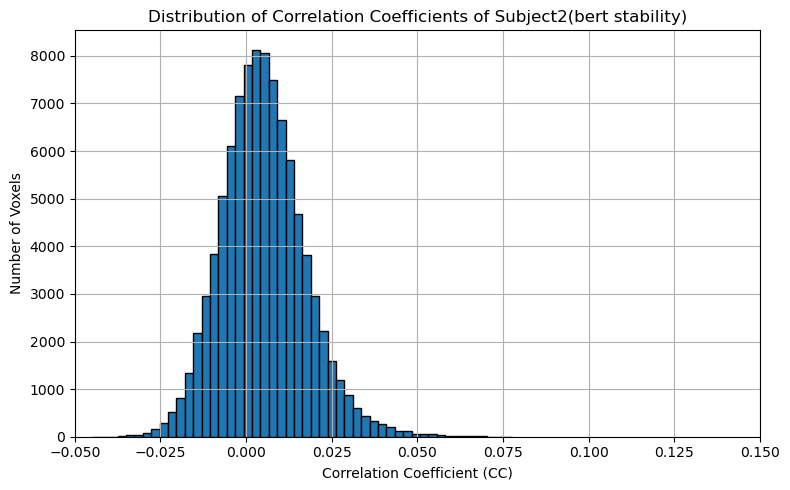

In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.hist(valid_ccs_s2, bins=50, edgecolor='black')
plt.title('Distribution of Correlation Coefficients of Subject2(bert stability)')
plt.xlabel('Correlation Coefficient (CC)')
plt.ylabel('Number of Voxels')
plt.grid(True)
plt.xlim(-0.05, 0.15)
plt.savefig("../figs/distribution_bert_stability2.png", dpi=300)
plt.tight_layout()
plt.show()

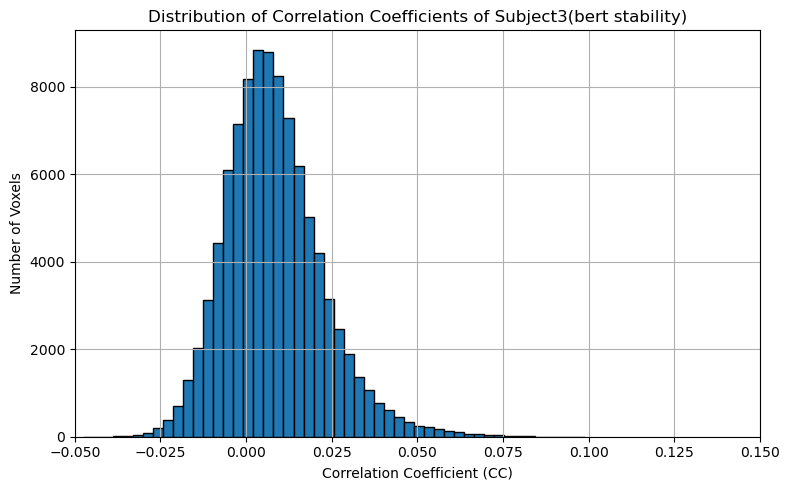

In [44]:
plt.figure(figsize=(8, 5))
plt.hist(valid_ccs_s3, bins=50, edgecolor='black')
plt.title('Distribution of Correlation Coefficients of Subject3(bert stability)')
plt.xlabel('Correlation Coefficient (CC)')
plt.ylabel('Number of Voxels')
plt.grid(True)
plt.xlim(-0.05, 0.15)
plt.savefig("../figs/distribution_bert_stability3.png", dpi=300)
plt.tight_layout()
plt.show()